In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from scipy import stats
import scipy as sc
import seaborn as sns

In [367]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
'''
Tomamos todas las banderas flags y las unimos en una sola columna llamada Flags
df=df.fillna(value="")
df["Flags"]=df["flag.1"]+" "+df["flag.2"]+" "+df["flag.3"]+" "+df["flag.4"]\
+" "+df["flag.5"] 
for i in range (1,6): del df["flag."+str(i)]
'''
'''
Hago un calculo de las freciencias de la energia Promedio, Aunque por ahora
no es muy pertinente para el analisis, tal vez si pueda hacerse algo después.
'''
plank=4.135667696*pow(10,-15)
vluz=3*pow(10,8)
Frec=[]
long=[]
for i in df['EnergiaProm']:
    Frec.append(i/plank)
    long.append(vluz/(i/plank))
df['Frec']=Frec
df['Long']=long

'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

def filtrof(data, Lbanderas): # Filtro por bandera, se podría agregar que eliminara también el rango de energía 3-6 keV
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
df['duration.ls']=np.log(df['duration.s'])
#lista=['NS','PE','P0']
#dff=filtrof(df,lista)
#print(dff.value_counts('flag.2'))

$$
\textbf{graficas y analisis de datos}
$$

In [368]:

'''hipotesis estadistica de eventos solares filtrados por rangos de energia"""
se filtran los datos con respecto al rango de las energias presentes 
en esas erupciones
'''
#df['energy.kev'].value_counts()
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
energy4 = Filtro(df,'energy.kev','50-100')
dfe=pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
dfdt = dfe['duration.s']
dfep = dfe['EnergiaProm']
datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
#plt.boxplot(datos)
#plt.figure(figsize=(4,4), dpi = 150)
#sns.boxplot(data=df.sort_values('EnergiaProm'),y='duration.s',x='energy.kev',hue='energy.kev')
#energy1.describe()

'diagrama de caja y bigote para la duracion \nde las eripciones con respecto a los rangos de energia'

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

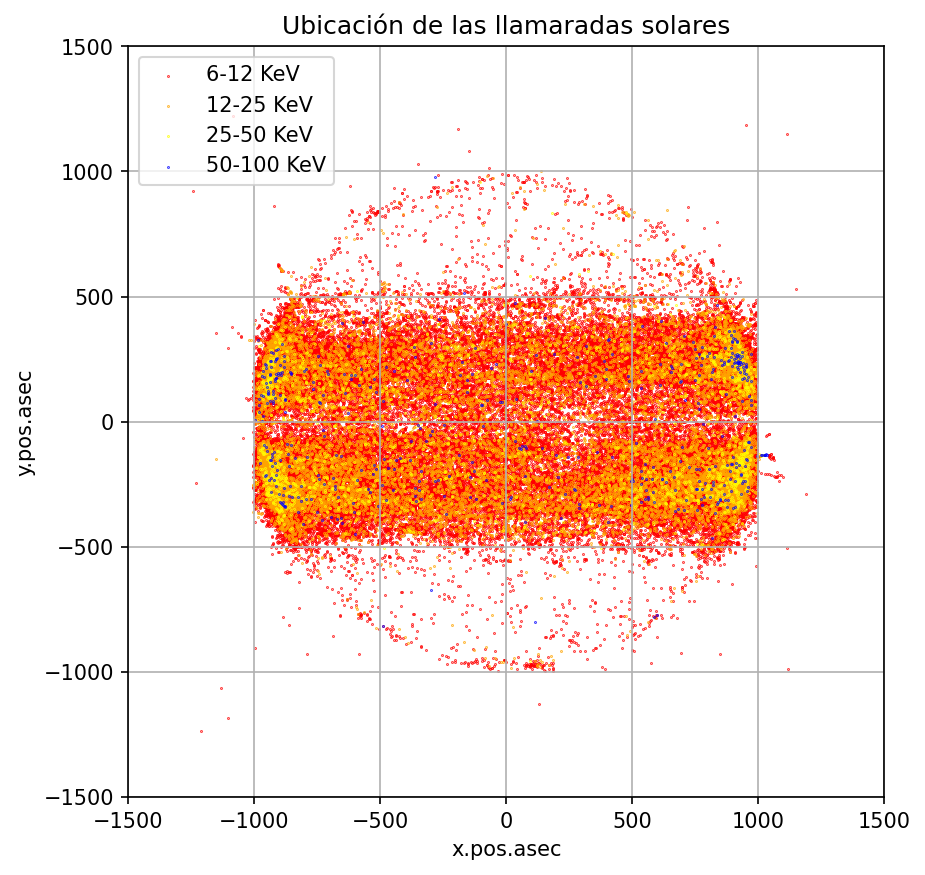

In [369]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
\textbf{Matriz de correlación}
$$

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

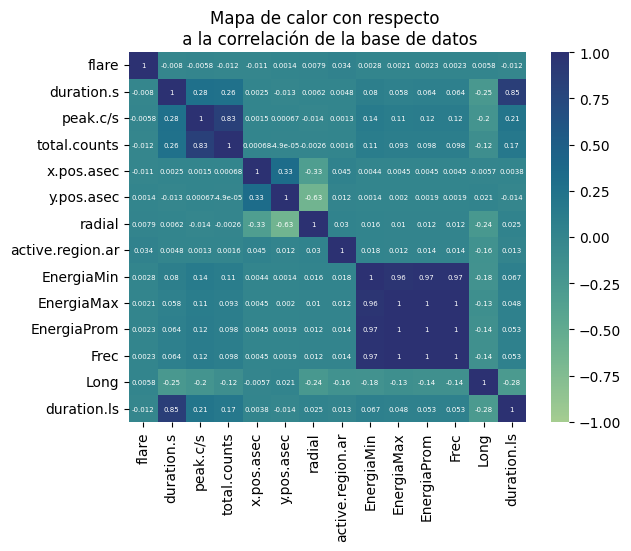

In [370]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''

matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5}
           ,vmin=-1,vmax=1)

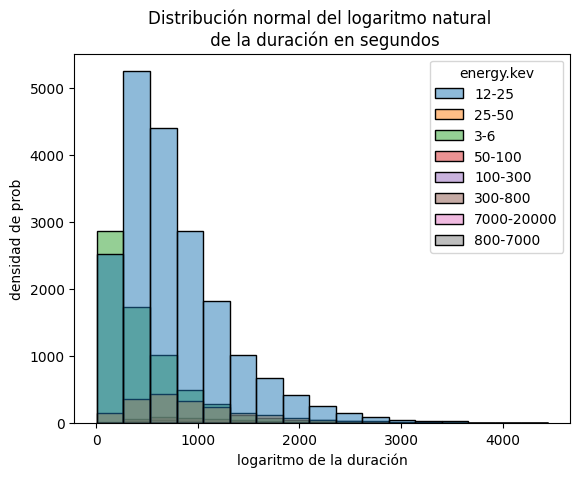

In [371]:
'''
ley de struggle e histograma
'''
dfef=df[df['energy.kev'] != '3-6']
k=1+np.log2(len(dfe['duration.s']))
dist=stats.lognorm
parametros= dist.fit(data=df['duration.ls'])
xap=np.linspace(min(df['duration.ls']),max(df['duration.ls']))
yap=dist.pdf(xap,*parametros)
plt.figure()
#plt.plot(xap,yap,label='aproximación para la duración \n a partir de una distribución log-normal',color='navy')
plt.title('Distribución normal del logaritmo natural \n de la duración en segundos')
plt.xlabel('logaritmo de la duración')
plt.ylabel('densidad de prob')
sns.histplot(data=dffe.sort_values('Datetime'),x='duration.s',hue='energy.kev',bins=int(k))
#plt.legend(loc='center left')
plt.savefig('logDuración')
#sns.kdeplot(data=df.sort_values('EnergiaProm'),x='duration.ls',hue='energy.kev')
#sns.histplot(data=dff.sort_values('Datetime'),x='duration.ls',hue='energy.kev',bins=int(k),kde=True)
#print(vardff)

<Figure size 640x480 with 0 Axes>

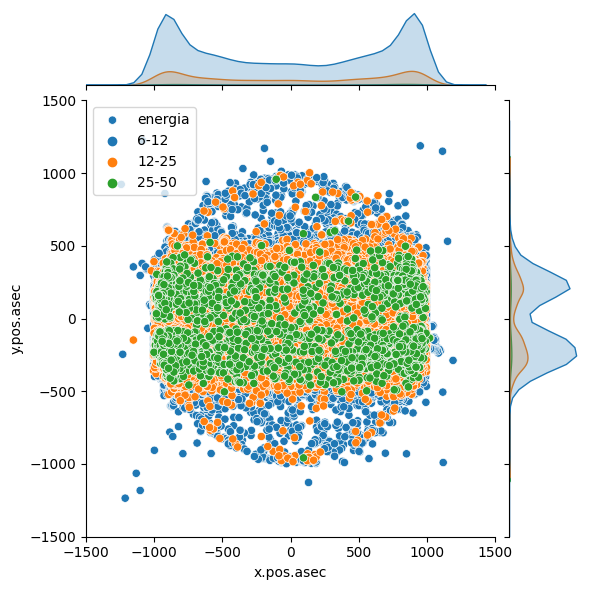

In [372]:
plt.figure()
sns.jointplot(dfe.sort_values('EnergiaProm'), x='x.pos.asec',y='y.pos.asec',kind='scatter',hue='energy.kev',xlim=(-1500,1500),ylim=(-1500,1500),label='energia')
plt.legend(loc='upper left')

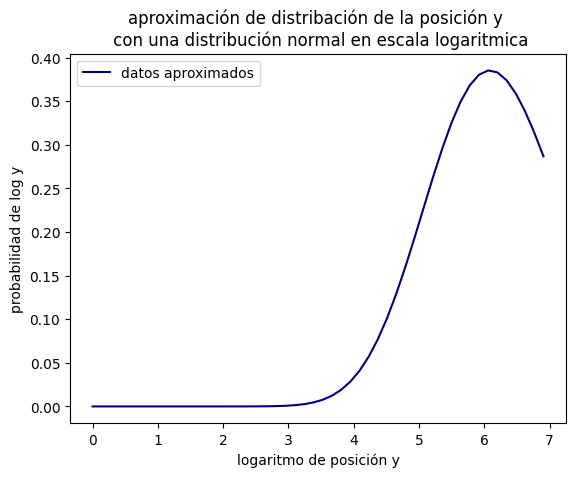

In [373]:
dfx=dfe[dfe['x.pos.asec'] > 0]
dfx=dfx[dfx['x.pos.asec'] < 1000]
dfy=dfe[dfe['y.pos.asec']> 0]
dfy=dfy[dfy['y.pos.asec']< 1000]
'''
aproximación de valores en y con una distribución normal en escala logaritmica
'''
dfx['log.x']=np.log(dfx['x.pos.asec'])
dfy['log.y']=np.log(dfy['y.pos.asec'])
#fil = dffy['energy.kev'] == '6-12' # Se filtra por rango de energias
#dataF = dffy[fil]
ky=1+np.log2(len(dfx['x.pos.asec']))
disty=stats.chi2
parametrosy= disty.fit(data=dfx['log.x'])
xapy=np.linspace(min(dfx['log.x']),max(dfx['log.x']))
yapy=disty.pdf(xapy,*parametrosy)
plt.figure()
#sns.kdeplot(data=dfx.sort_values('Datetime'),x='log.x',hue='energy.kev',label='logaritmo de posición y de los datos')
plt.title('aproximación de distribación de la posición y \n con una distribución normal en escala logaritmica')
plt.plot(xapy,yapy,label='datos aproximados',color='navy')
plt.xlabel('logaritmo de posición y')
plt.ylabel('probabilidad de log y')
plt.legend()
#plt.savefig('DistY')
#sns.histplot(data=dfy.sort_values('Datetime'))

In [374]:
#sns.kdeplot(data=dffe.sort_values('EnergiaProm'),x='x.pos.asec',y='y.pos.asec',hue='energy.kev',xlim=(-1000,1000),ylim=(-1000,1000))

<AxesSubplot:xlabel='log.x', ylabel='Density'>

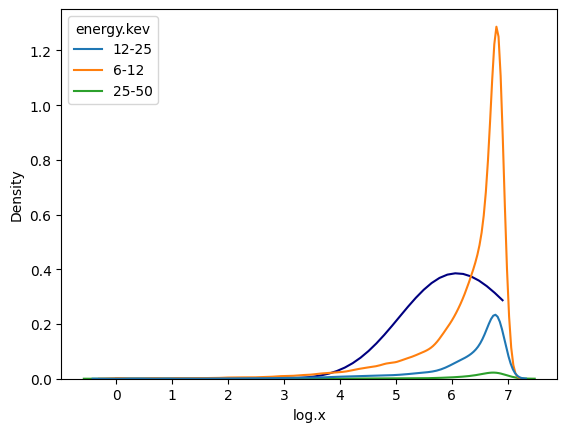

In [375]:
'''
aproximación de los valores en x
'''
dfx['log.x']=np.log(dfx['x.pos.asec'])
kx=1+np.log2(len(dfx['y.pos.asec']))

#sns.histplot(data=dffx.sort_values('Datetime'),x='x.pos.asec',hue='energy.kev',bins=int(kx))
distx=stats.norm
parametrosx= distx.fit(data=dfx['log.x'])
xapx=np.linspace(min(dfx['log.x']),max(dfx['log.x']))
yapx=disty.pdf(xap,*parametrosx)
plt.figure()
plt.plot(xapy,yapy,label='datos aproximados',color='navy')
sns.kdeplot(dfx.sort_values('Datetime'),x='log.x',hue='energy.kev')

$$
\textbf{Prueba de hipotesis t de student y f de fisher para las duraciones}
$$
se realizan dos funciones en las que se trabajan unas pruebas de hipotesis con respecto a los Funciones de distribución t de student y F de Fisher para determinar si hay una diferencia significativa entre las medias poblacionales y aunque en un principio se intentó con una t student la verdad es que la evaluación de su estadistico proporcionaba valores (pvalores, e intervalos) que en primer lugar carecian de sentido pues aunque los datos mostrabán unas diferencias con respecto a los valores de duracion promedio dependiendo de la energía, y se observa una independencia del promedio de estos valores entre los rangos energeticos (osea la duracion media de las llamaradas de cada valor de energia es independiente del resto de valores en los que no se encuentra)
al plantear la hipotesis nula en la que las medias poblacionales para los valores de energia eran iguales para la F de fisher se observó que el nivel de significancia fue muy bajo ademas que el estadistico de esta hipotesis , queda fuerá del intervalo de confianza. Por lo que se tienen suficientes argumentos para rechazar la hipotesis nula.

In [397]:
def PDMT(dfa,dfb,col,alpha,hip):
    proa=dfa[col].mean()
    prob=dfb[col].mean()
    na=len(dfa[col])
    nb=len(dfb[col])
    sta=dfa[col].std(ddof=(na-1))
    stb=dfb[col].std(ddof=(nb-1))
    Promdif=prob-proa
    v=pow((pow(sta,2)/na)+(pow(stb,2)/nb),2)/((pow(pow(sta,2)/na,2)/na-1)+(pow(pow(stb,2)/nb,2)/nb-1))
    kv=int(v)
    Tdeno=np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb))
    Tnume=(Promdif-hip)
    Test=Tnume/Tsub
    conf=(1.0-alpha)
    cv=stats.t.ppf(conf, kv)
    coin=Tnume-(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    coif=Tnume+(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    ps=1.0-sc.special.stdtr(kv,np.abs(T))
    p=(1.0-stats.t.cdf(np.abs(Test),kv))
    return T, coin, coif, cv, Promdif,p

def PDVF(dfa,dfb,col,alpha):
    pro1=dfa[col].mean()
    pro2=dfb[col].mean()
    n1=len(dfa[col])
    n2=len(dfb[col])
    dof1=(n1-1)
    dof2=(n2-1)
    conf=1.0-alpha
    st1=dfa[col].std(ddof=dof1)
    st2=dfb[col].std(ddof=dof2)
    fsup=stats.f.ppf(alpha,dof2,dof1)
    finf=(1/fsup)
    Fest=pow(st1,2)/pow(st2,2)
    pf=1.0-stats.f.cdf(abs(Fest),dof1,dof2)
    return fsup, finf , Fest , pf

In [398]:
pruebaEnergiaDuracionT=PDMT(energy1,energy3,'duration.s',0.025,0)
pruebaEnergiaDuracionF=PDVF(energy1,energy3,'duration.s',0.025)
print(pruebaEnergiaDuracionF)
print(pruebaEnergiaDuracionT)

(0.939114536689469, 1.0648328408642913, 9.857397112740983, 1.1102230246251565e-16)
(0.27008850739923684, -916.3391737545243, 2126.883005477218, 1.9607248618821873, 605.2719158613469, 0.24805492311905675)


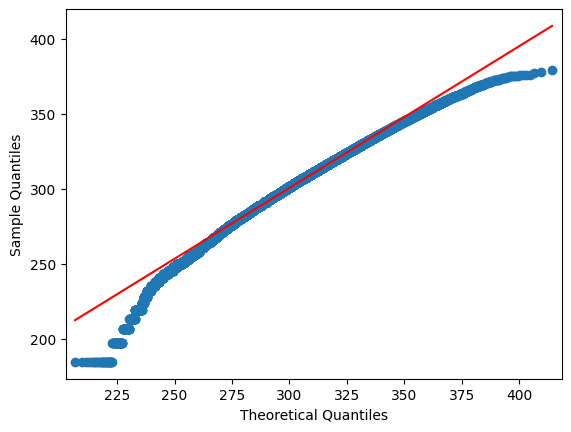

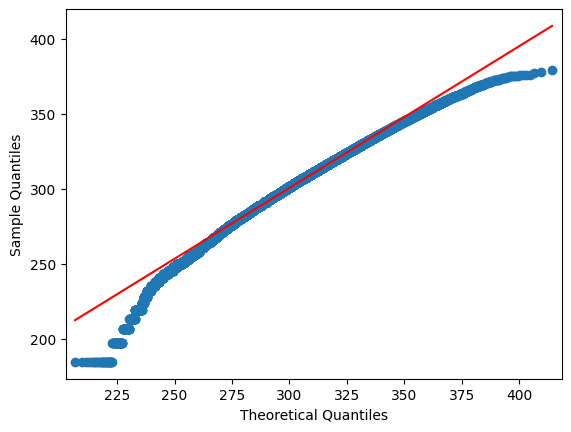

In [381]:
#sm.qqplot?
sm.qqplot(data=energy1['duration.ls'], dist=stats.chi2 , fit=True, line='q')

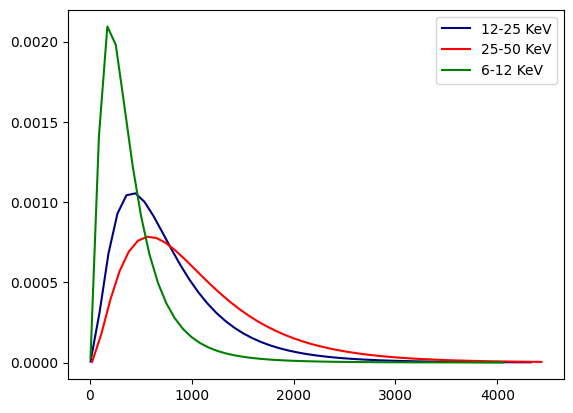

In [184]:
distchi2=stats.f
df=len(energy2['duration.s'])-1
parametroschi1= distchi2.fit(data=energy1['duration.s'])
parametroschi3= distchi2.fit(data=energy3['duration.s'])
parametroschi2= distchi2.fit(data=energy2['duration.s'])
xachi2=np.linspace(min(energy2['duration.s']),max(energy2['duration.s']))
yachi2=distchi2.pdf(xachi2,*parametroschi2)
xachi3=np.linspace(min(energy3['duration.s']),max(energy3['duration.s']))
yachi3=distchi2.pdf(xachi2,*parametroschi3)
xachi1=np.linspace(min(energy1['duration.s']),max(energy1['duration.s']))
yachi1=distchi2.pdf(xachi1,*parametroschi1)
plt.figure()
plt.plot(xachi2,yachi2,label='12-25 KeV',color='navy')
plt.plot(xachi3,yachi3,label='25-50 KeV',color='red')
plt.plot(xachi1,yachi1,label='6-12 KeV',color='green')
plt.legend()

In [347]:
stats.ttest_1samp(a=energy2['duration.s'],popmean=dfe['duration.s'].mean())

Ttest_1sampResult(statistic=73.33127704063902, pvalue=0.0)

In [135]:
#print(energy5['Long'])

Datetime
2002-02-26 10:25:40    6.203502e-09
2002-04-04 15:26:00    6.203502e-09
2002-04-10 12:25:44    6.203502e-09
2002-04-12 17:27:24    6.203502e-09
2002-04-21 00:39:44    6.203502e-09
                           ...     
2017-09-09 03:57:16    6.203502e-09
2017-09-10 15:52:36    6.203502e-09
2017-09-10 16:39:36    6.203502e-09
2017-09-10 19:19:04    6.203502e-09
2017-09-10 22:09:32    6.203502e-09
Name: Long, Length: 218, dtype: float64


In [22]:
'''
intervalo de aproximación de una variable
'''
gradosf=na-1
Tunid=sta/np.sqrt(nb)
#Tun=Proa
cvu=stats.t.ppf(conf,gradosf)
coina=abs(proa-cvu*Tunid)
coifa=proa+cvu*Tunid
print(coina)
print(coifa)
print(energy2['duration.s'].mean())

2017.3142121942933
3573.188938476312
777.9373631410093


<AxesSubplot:xlabel='duration.s', ylabel='Count'>

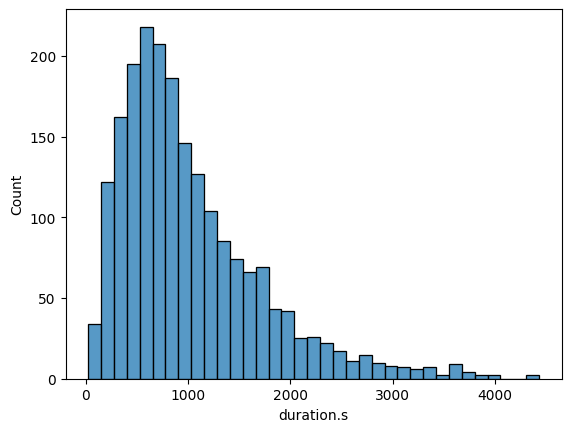

In [20]:
sns.histplot(data=energy3,x='duration.s')